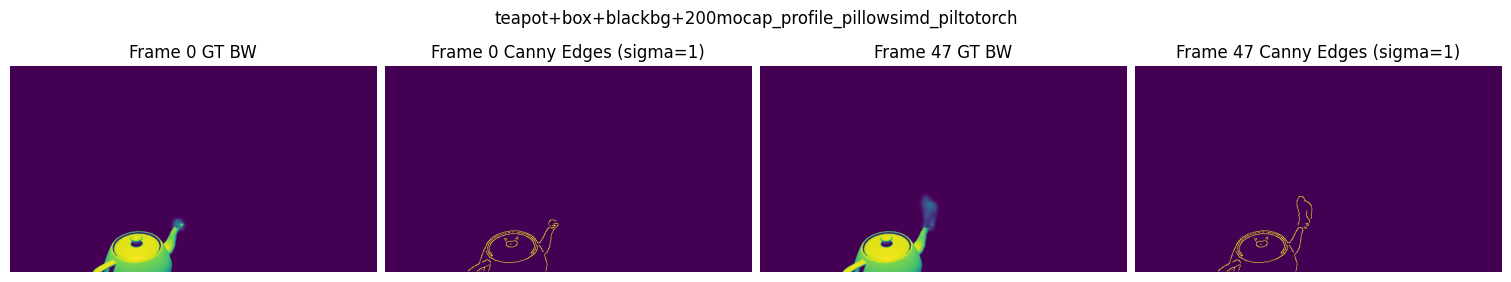

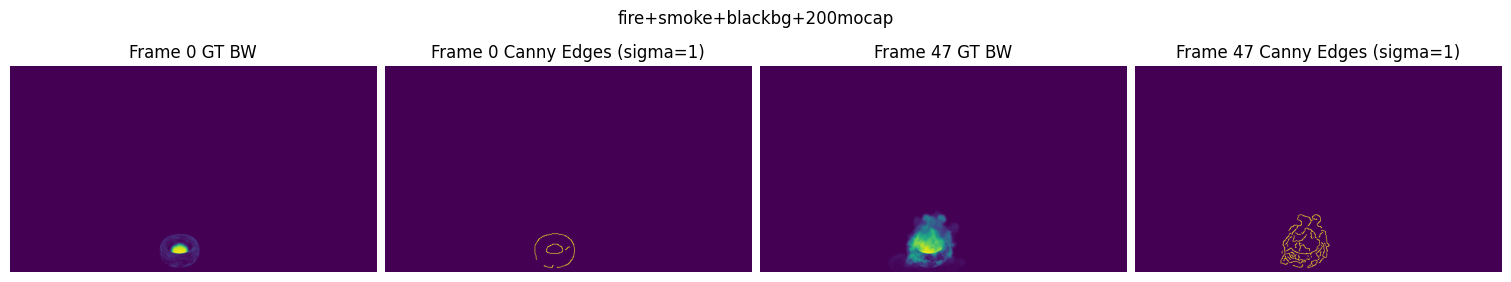

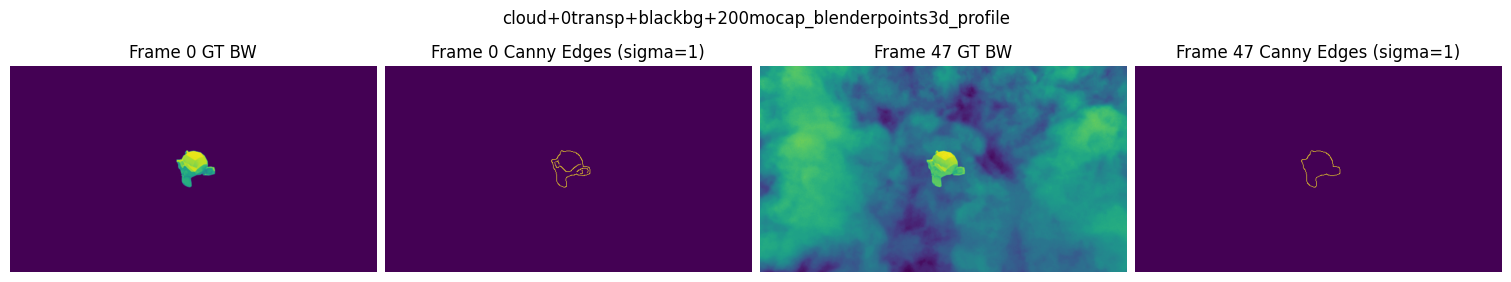

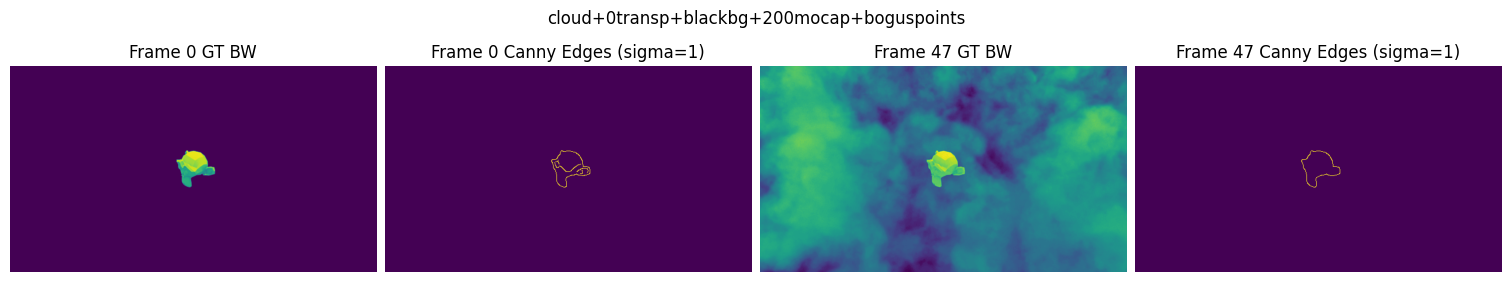

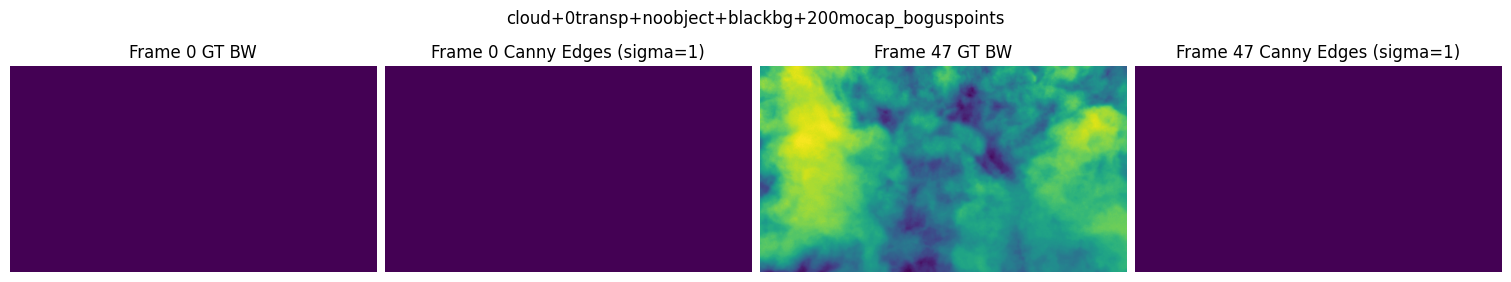

In [6]:
# canny filter contour extraction
from pathlib import Path
from typing import Iterable
from matplotlib.axes import Axes
from skimage import feature
from skimage.color import rgb2gray
import skimage as skim
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def crop_to_edges(image: np.ndarray, edges: np.ndarray, padding=0) -> np.ndarray:
    y, x = np.where(edges)
    return image[y.min() - padding:y.max() + padding,  x.min() - padding: x.max() + padding]



basepath = Path(
    "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/")
testdirs = [
    "teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch",
    "fire+smoke+blackbg+200mocap",
    "cloud+0transp+blackbg+200mocap_blenderpoints3d_profile",
    "cloud+0transp+blackbg+200mocap+boguspoints",
    "cloud+0transp+noobject+blackbg+200mocap_boguspoints",
]


sigmas = [1]
for testdir in (basepath/t/"test/ours_30000" for t in testdirs):
    fig, axs = plt.subplots(nrows=len(sigmas), ncols=4, figsize=(5*3, 3*len(sigmas)), layout="constrained")
    fig.suptitle(testdir.parts[-3])
    if type(axs) is not np.ndarray:
        axs: np.ndarray[Axes] = np.array(axs)
    iaxs: Iterable[Axes] = axs.flat
    for sigma in sigmas:
        for imno in [0, 47]:
            gt, render = [skim.io.imread(
                testdir/p/f"{imno:>05}.png") for p in ["gt", "renders"]]
            gt_bw = rgb2gray(gt)
            edges: np.ndarray = feature.canny(gt_bw, sigma=sigma)
            for title, image in zip([f"Frame {imno} GT BW", f"Frame {imno} Canny Edges (sigma={sigma})"], [gt_bw, edges]):
                ax: Axes = next(iaxs)
                ax.axis('off')
                ax.set_title(title)
                ax.imshow(image)

In [ ]:
from typing import Callable
from skimage.filters import *
import numpy as np


def identity(i): return i

images = [47]
filters: list[Callable[[np.ndarray], np.ndarray]] = [
    identity, laplace, sobel, scharr, roberts, 
]
for testdir in (basepath/t/"test/ours_30000" for t in testdirs):
    fig, axs = plt.subplots(
        len(images), len(filters), layout="constrained", figsize=(16, 4))
    axs: np.ndarray[Axes] = np.array(axs)
    iaxs = axs.flat
    for impath in [testdir/"gt"/f"{p:>05}.png" for p in images]:
        image = skim.io.imread(impath)
        for ffilter in filters:
            ax: Axes = next(iaxs)
            im_filtered = ffilter(rgb2gray(image))
            if im_filtered.dtype == np.uint8:
                im_filtered = im_filtered.astype(np.float32) / 255
            else:
                im_filtered = np.abs(im_filtered)
                im_filtered -= im_filtered.min()
                im_filtered /= np.ptp(im_filtered)
            ax.axis('off')
            ax.set_title(ffilter.__name__)
            ax.imshow(im_filtered)

NameError: name 'np' is not defined

/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/home/aq85800/anaconda3/envs/plotenv/lib/python3.12/site-packages/skimage/metrics/_structural_similarity.py:279: RuntimeWarning: invalid value encountered in divide
  grad = filter_func(A1 / D, **filter_args) * im1


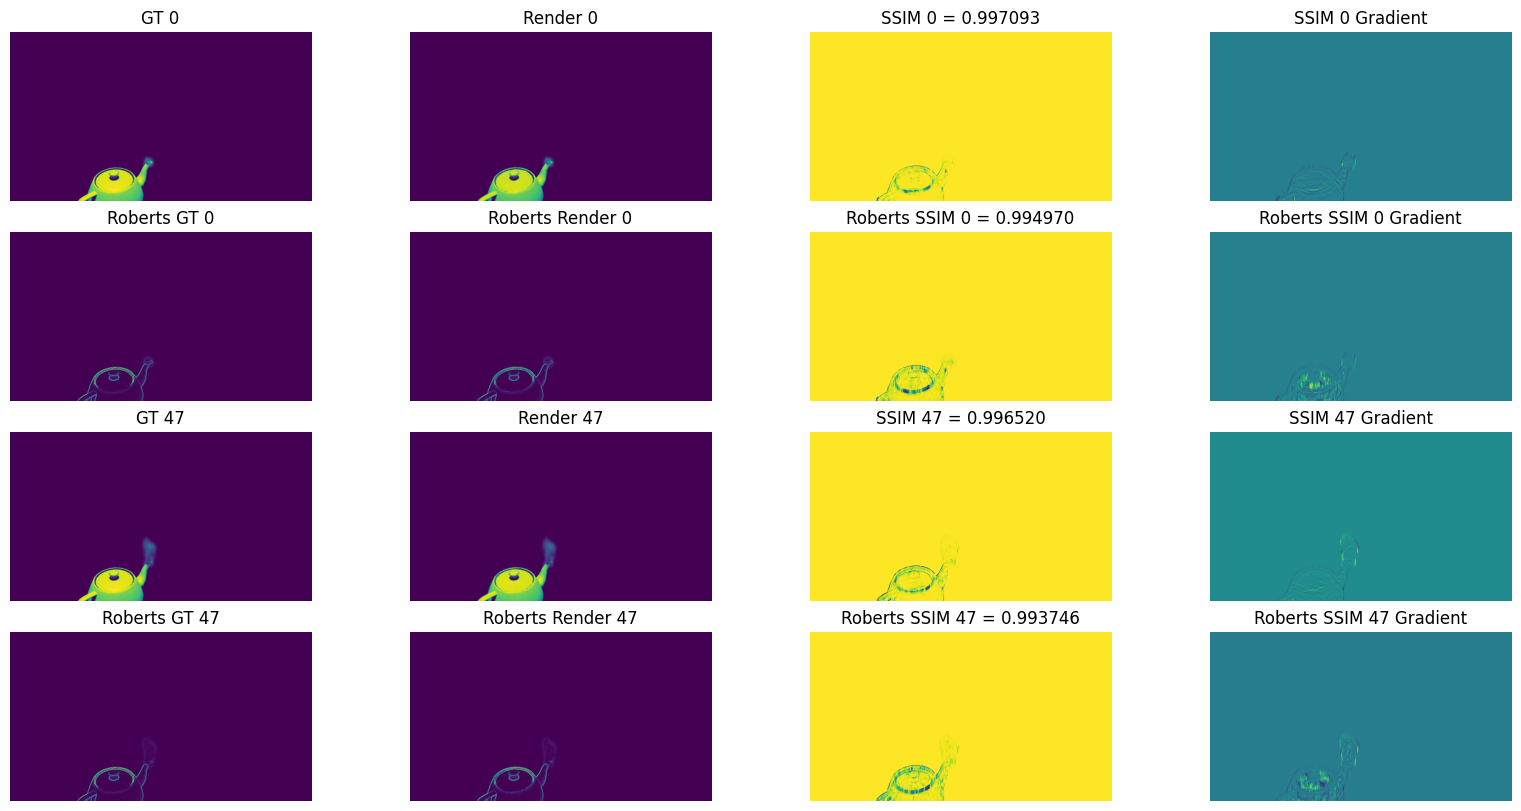

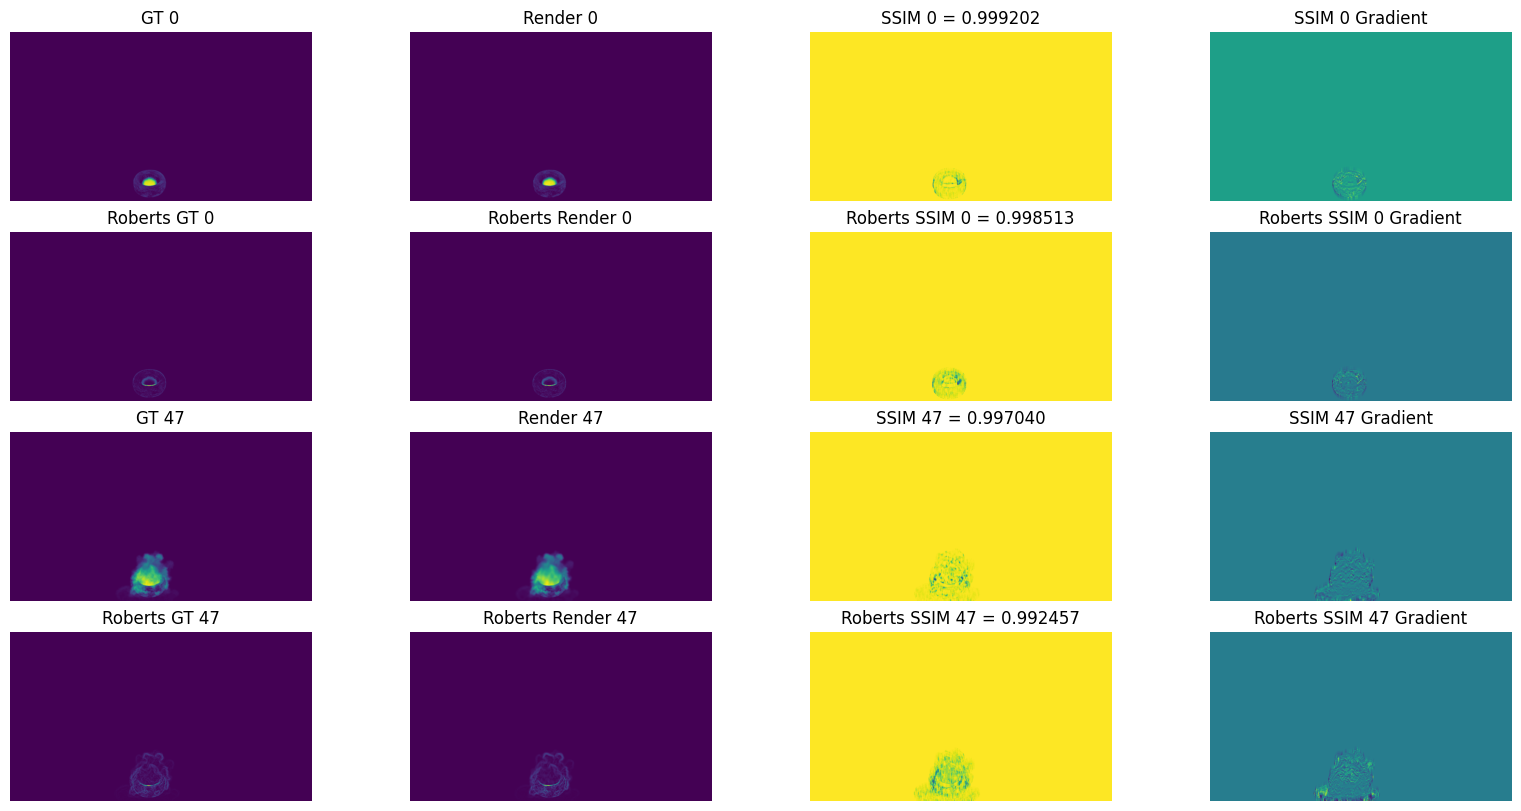

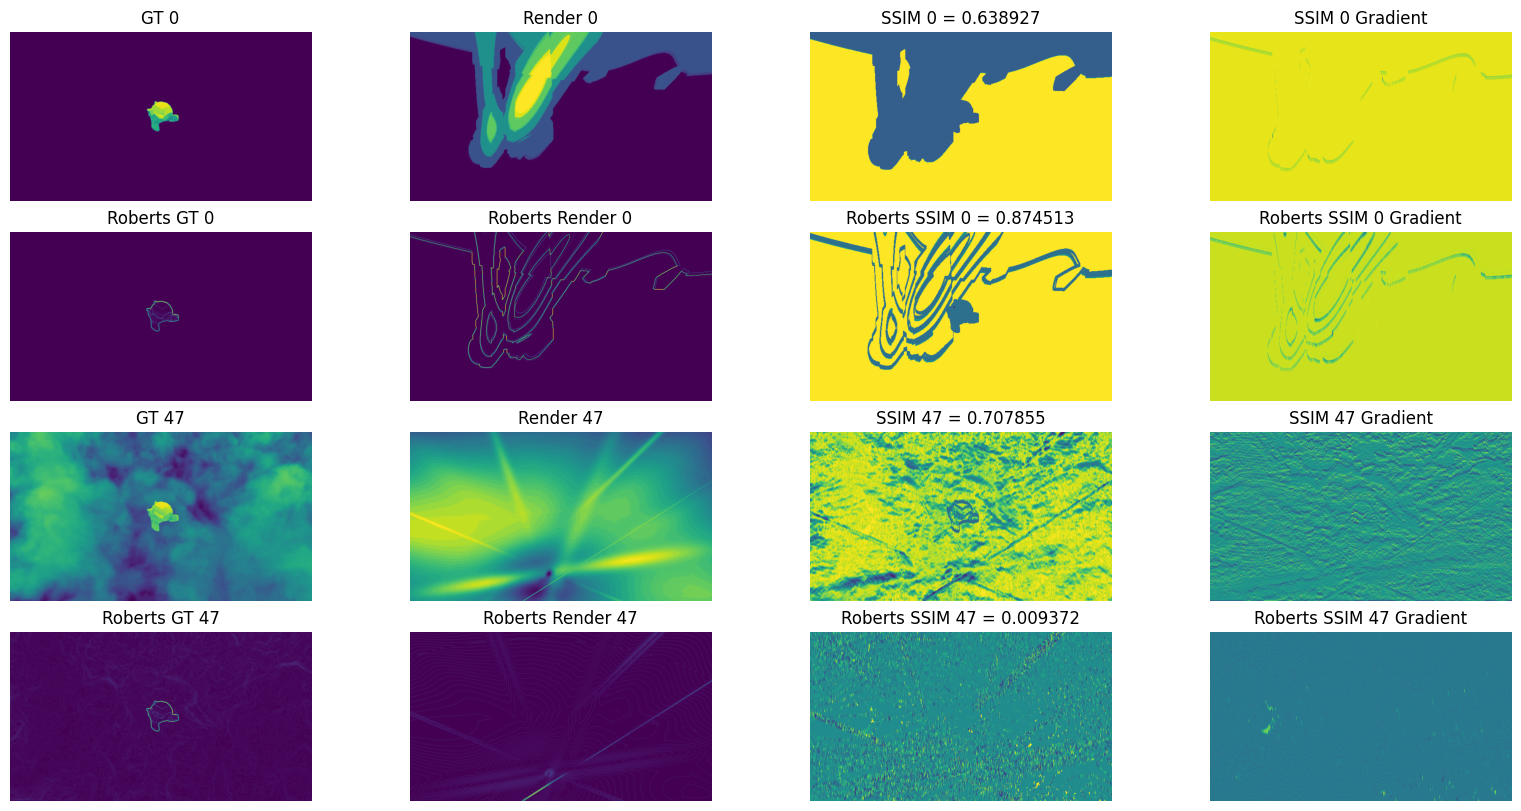

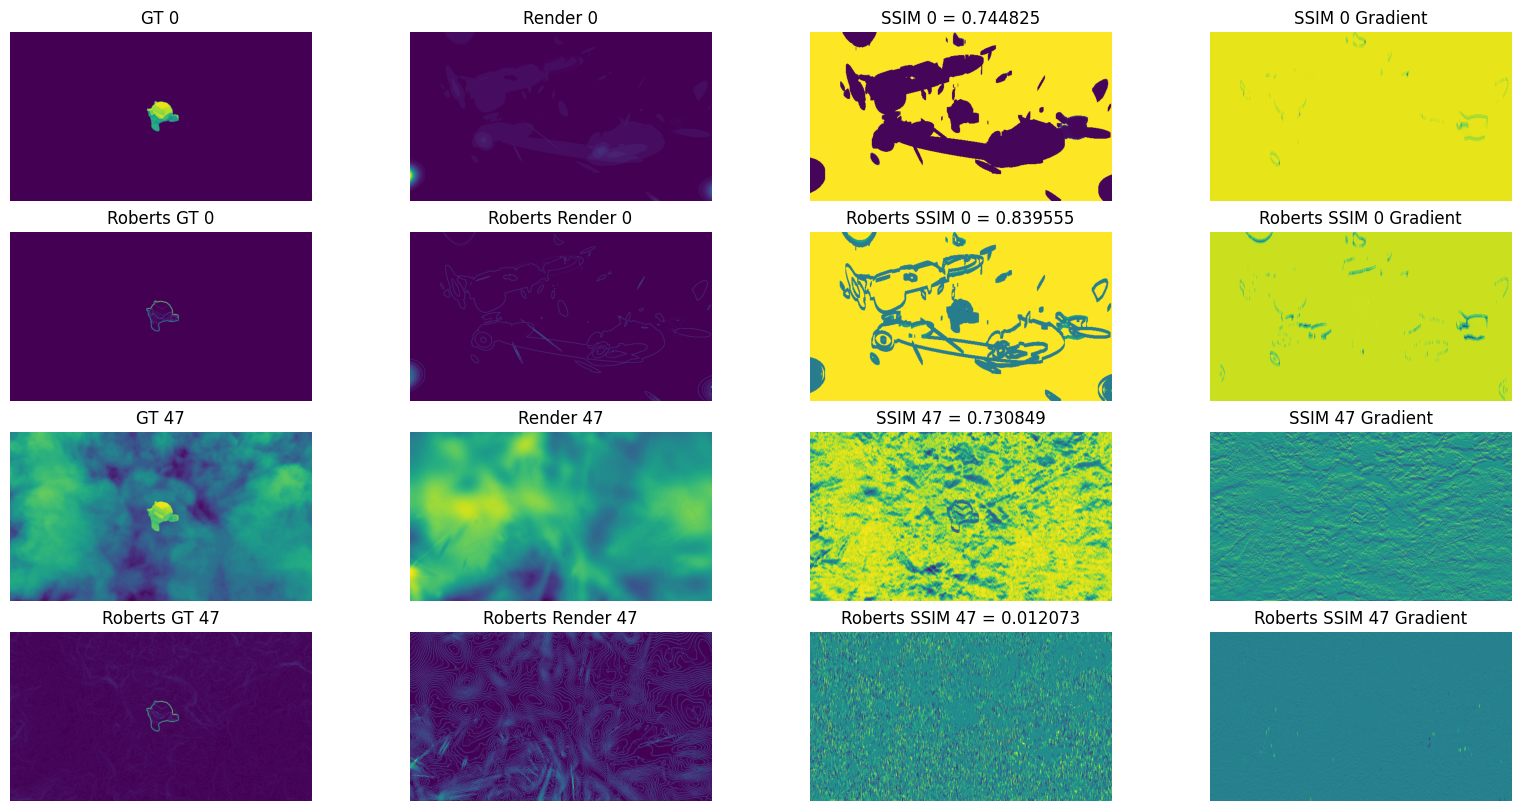

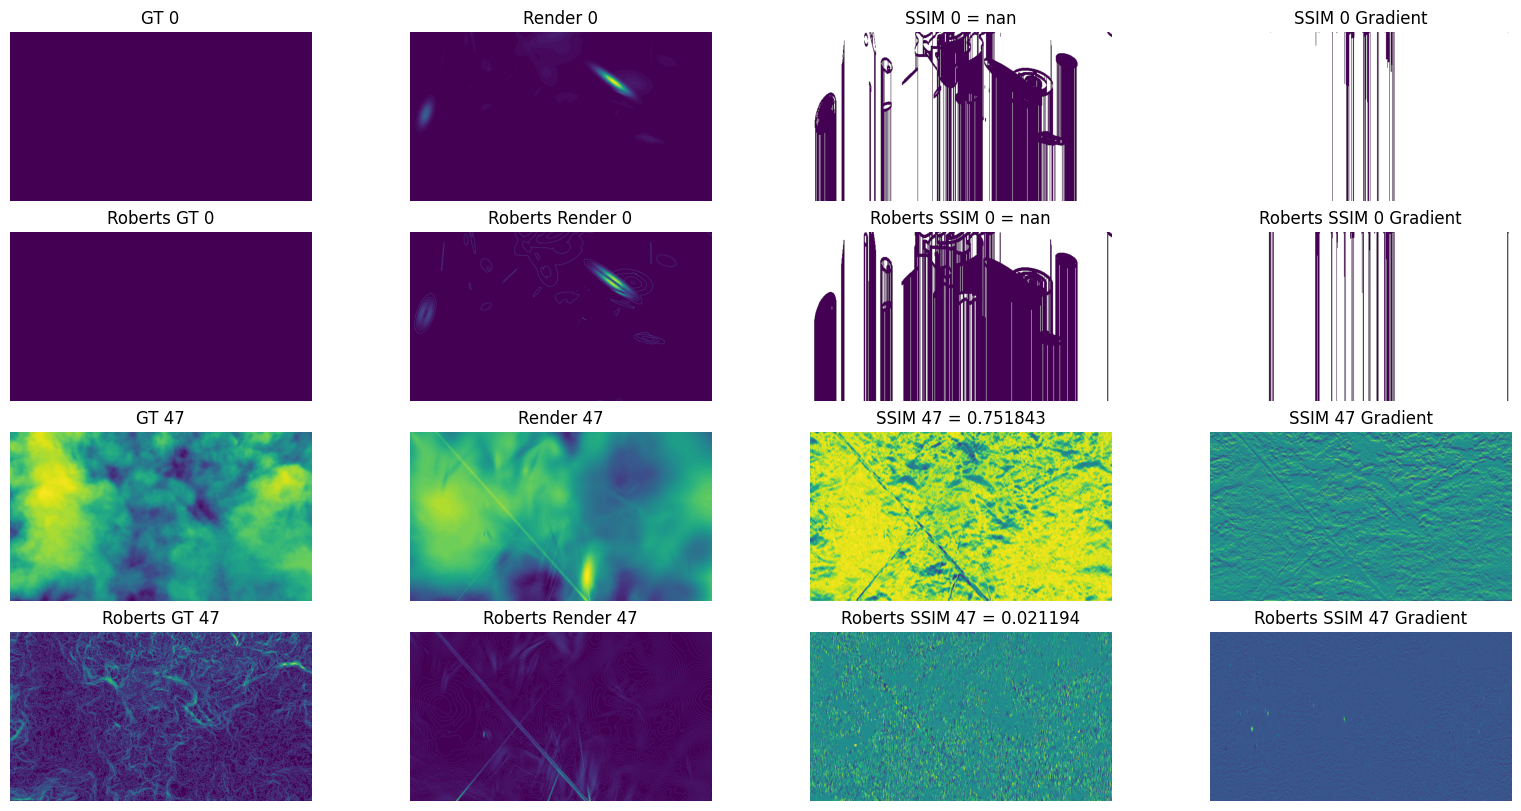

In [8]:
for testdir in (basepath/t/"test/ours_30000" for t in testdirs):
    fig, axs = plt.subplots(
        nrows=4, ncols=4, layout="constrained", figsize=(16, 8))
    axs: np.ndarray[Axes] = np.array(axs)
    iaxs = axs.flat

    for imno in [0, 47]:
        p_gt, p_render = [testdir/d/f'{imno:>05}.png' for d in ['gt', 'renders']]
        i_gt, i_render = [rgb2gray(skim.io.imread(p)) for p in [p_gt, p_render]]
        max_val = np.amax(np.fmin(i_gt, i_render))
        min_val = np.amin(np.fmin(i_gt, i_render))
        v_ssim, i_gssim, i_ssim = ssim(
            i_gt, i_render, data_range=max_val - min_val, channel_axis=-1, gradient=True, full=True)
        image_row = zip([i_gt, i_render, i_ssim, i_gssim], [f"GT {imno}", f"Render {imno}", f"SSIM {imno} = {v_ssim:.6f}", f"SSIM {imno} Gradient"])

        i_scharr_gt, i_scharr_render = [roberts(i) for i in [i_gt, i_render]]
        max_val = np.amax(np.fmin(i_scharr_gt, i_scharr_render))
        min_val = np.amin(np.fmin(i_scharr_gt, i_scharr_render))
        v_scharr_ssim, i_scharr_gssim, i_scharr_ssim = ssim(
            i_scharr_gt, i_scharr_render, data_range=max_val - min_val, channel_axis=-1, gradient=True, full=True)
        scharr_row = zip([i_scharr_gt, i_scharr_render, i_scharr_ssim, i_scharr_gssim], [f"Roberts GT {imno}", f"Roberts Render {imno}", f"Roberts SSIM {imno} = {v_scharr_ssim:.6f}", f"Roberts SSIM {imno} Gradient"])

        for i, title in [*image_row, *scharr_row]:
            ax: Axes = next(iaxs)
            ax.axis('off')
            ax.set_title(title)
            ax.imshow(i)



In [9]:
# import pathlib
# import functools
# from timeit import timeit
# from typing import Any, Callable


# def ssim_full(**kwargs):
#     return ssim(
#         gt, render, channel_axis=2, data_range=gt.max() - gt.min(), **kwargs)


# def ssim_edge_crop(**kwargs):
#     gt_bw = rgb2gray(gt)
#     edges: np.ndarray = feature.canny(gt_bw)
#     cropped_render = crop_to_edges(render, edges, 30)
#     cropped_gt = crop_to_edges(gt, edges, 30)
#     return ssim(
#         cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min(), **kwargs)


# def memoize_custom_hash(func, custom_hash):
#     cache = {}

#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         key = custom_hash(*args, **kwargs)
#         return cache.setdefault(key, func(*args, **kwargs))
#     return wrapper


# def hash_ndarray(array: np.ndarray):
#     return hash(array.tobytes())


# def find_edges(gt: np.ndarray):
#     gt_bw = rgb2gray(gt)
#     edges: np.ndarray = feature.canny(gt_bw)
#     return edges


# find_edges = memoize_custom_hash(find_edges, hash_ndarray)


# def ssim_cached_edge_crop():
#     edges = find_edges(gt)
#     cropped_render = crop_to_edges(render, edges, 30)
#     cropped_gt = crop_to_edges(gt, edges, 30)
#     return ssim(
#         cropped_gt, cropped_render, channel_axis=2, data_range=cropped_gt.max() - cropped_gt.min())


# test = (ssim_full(), ssim_edge_crop(), ssim_cached_edge_crop())
# print("SSIMs:", test)
# eps = 1e-6
# for t in test[1:]:
#     assert test[1]-eps < t < test[1]+eps, f"SSIM values are not equal: {test}"

# gts = [plt.imread(f) for f in sorted(pathlib.Path(
#     "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/gt").glob("*.png"))]
# renders = [plt.imread(f) for f in sorted(pathlib.Path(
#     "/mnt/NewVolume/aq85800/SpacetimeGaussians/output_blender_prior/techni_lite_noprior48/teapot+box+blackbg+200mocap_profile_pillowsimd_piltotorch/test/ours_30000/renders").glob("*.png"))]
# for i, (gt, render) in enumerate(zip(gts, renders)):
#     test = (ssim_full(), ssim_edge_crop(), ssim_cached_edge_crop())
#     print(f"SSIMs of {i}:", test)

# number = int(1e3)
# times = (
#     timeit(
#         setup="from __main__ import ssim_full",
#         stmt="""ssim_full()""",
#         number=number,
#     ),
#     timeit(
#         setup="from __main__ import ssim_edge_crop",
#         stmt="""ssim_edge_crop()""",
#         number=number,
#     ),
#     timeit(
#         setup="from __main__ import ssim_cached_edge_crop",
#         stmt="""ssim_cached_edge_crop()""",
#         number=number,
#     ),
# )
# for t, expname in zip(times, ("ssim_full", "ssim_edge_crop", "ssim_cached_edge_crop")):
#     print(f"{expname:30}: {t:.6f} seconds")